In [19]:
from functools import partial
import math
import os
from typing import Callable

import tqdm

import numpy as np

import jax
import jax.numpy as jnp

import equinox as eqx

import optax

from jaxtyping import PyTree, Array, Float, PRNGKeyArray

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter

from model import UNet

key = jax.random.key(0)

# Load Data

In [2]:
def load_data(data_root):
    """
    data_root 경로 안의 train, validation, test 폴더에서
    gt_images, gt_masks, tomo_images, gt_pos_list 파일을 읽어와서
    딕셔너리 형태로 반환합니다.

    Parameters
    ----------
    data_root : str
        '.../data' 의 상위 경로. 내부에 train/, validation/, test/ 가 있어야 합니다.

    Returns
    -------
    data : dict
        {
            'train': {
                'gt_images': np.ndarray,
                'gt_masks': np.ndarray,
                'tomo_images': np.ndarray,
                'gt_pos_list': np.ndarray (dtype=object)
            },
            'validation': { ... },
            'test': { ... }
        }
    """
    labels = ['train', 'validation', 'test']
    data = {}

    for lbl in labels:
        folder = os.path.join(data_root, lbl)
        if not os.path.isdir(folder):
            raise FileNotFoundError(f"Directory not found: {folder}")

        gt_images   = np.load(os.path.join(folder, 'gt_images.npy'))
        gt_masks    = np.load(os.path.join(folder, 'gt_masks.npy'))
        tomo_images = np.load(os.path.join(folder, 'tomo_images.npy'))
        gt_pos_list = np.load(os.path.join(folder, 'gt_pos_list.npy'), allow_pickle=True)

        data[lbl] = {
            'gt_images':   gt_images,
            'gt_masks':    gt_masks,
            'tomo_images': tomo_images,
            'gt_pos_list': gt_pos_list,
        }

    return data

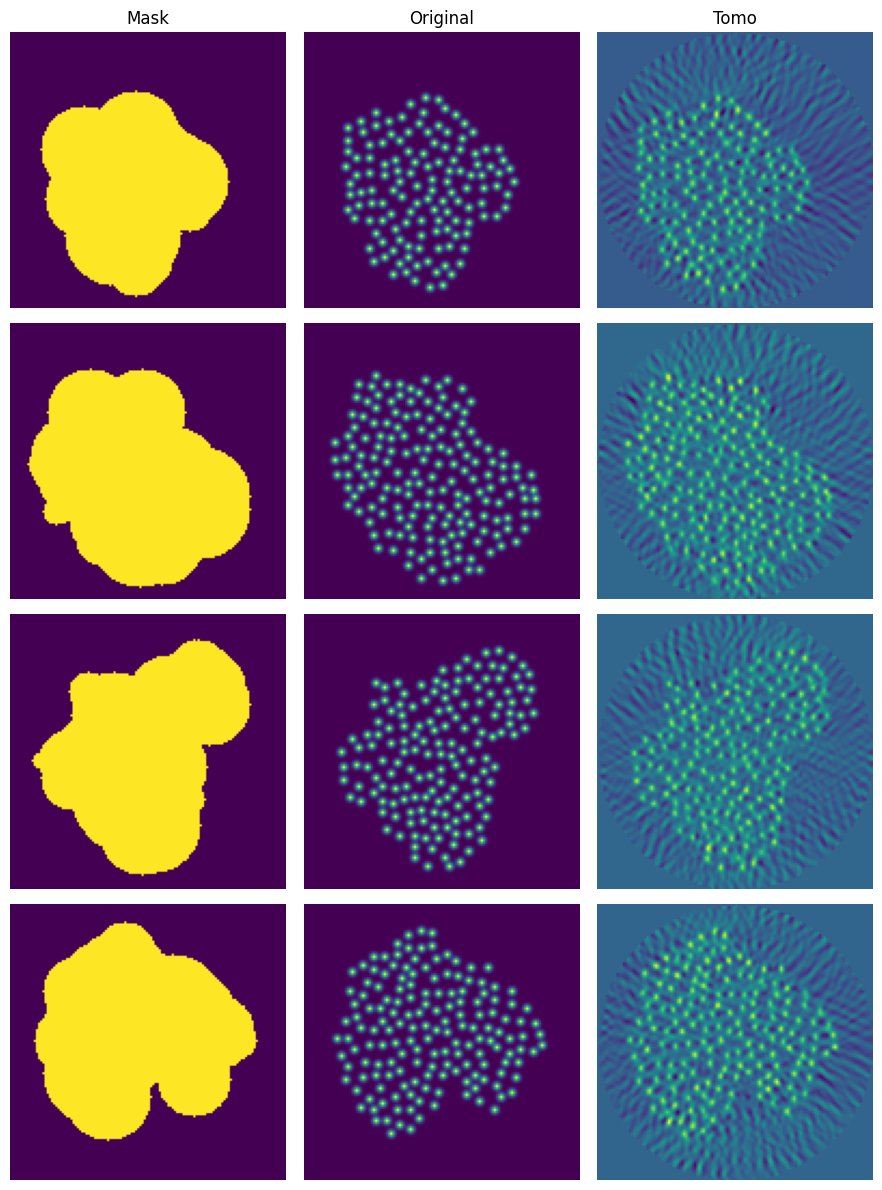

In [3]:
data = load_data("./data")
N = 4
gt_images = data['train']['gt_images'][:N]
gt_masks = data['train']['gt_masks'][:N]
data_images = data['train']['tomo_images'][:N]

fig, axes = plt.subplots(N, 3, figsize=(9, N * 3))

axes[0][0].set_title(f"Mask")
axes[0][1].set_title(f"Original")
axes[0][2].set_title(f"Tomo")

for idx in range(N):
    axes[idx][0].imshow(gt_masks[idx])
    axes[idx][1].imshow(gt_images[idx])
    axes[idx][2].imshow(data_images[idx])
    
for ax in axes.flatten():
    ax.axis('off')
    
plt.tight_layout()
plt.show()


In [4]:
def data_loader(data, batch_size, *, key, infinite=False):
    gt_images = data['gt_images']
    tomo_images = data['tomo_images']
    gt_images = gt_images[:, None, ...]     # (N, 1, H, W)
    tomo_images = tomo_images[:, None, ...] # (N, 1, H, W)
    
    dataset_size = gt_images.shape[0]
    indices = jnp.arange(dataset_size)
    
    while True:
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, indices)
        for start in range(0, N, batch_size):
            batch_idx = perm[start : start + batch_size]
            yield tomo_images[batch_idx], gt_images[batch_idx]
            
        if not infinite:
            break

## Train loop

In [5]:
@eqx.filter_value_and_grad(has_aux=True)
def compute_grad(
    model: eqx.Module,
    model_state: eqx.nn.State,
    tomo: Float[Array, "b c h w"],
    original: Float[Array, "b c h w"]
):
    outputs, model_state = jax.vmap(model, axis_name='batch', in_axes=(0, None), out_axes=(0, None))(tomo, model_state)
    mse_loss = jnp.mean((original - outputs) ** 2)
    return mse_loss, model_state

@eqx.filter_jit
def eval_step(
    model: eqx.Module,
    model_state: eqx.nn.State,
    tomo: Float[Array, "b c h w"],
    orig: Float[Array, "b c h w"]
):
    outputs, _ = jax.vmap(model, axis_name='batch', in_axes=(0, None), out_axes=(0, None))(tomo, model_state)
    return jnp.mean((orig - outputs) ** 2)

def evaluate(model, model_state, loader, n_steps):
    eval_model = eqx.nn.inference_mode(model, value=True)
    losses = []
    
    step_iter = iter(loader)
    for _ in range(n_steps):
        tomo, orig = next(step_iter)
        losses.append(float(eval_step(eval_model, model_state, tomo, orig)))
    return sum(losses) / len(losses)

def train(
    model: eqx.Module,
    optim: optax.GradientTransformation,
    model_state: eqx.nn.State,
    opt_state: optax.OptState,
    data: dict,
    n_epochs: int,
    n_batches: int,
    key: PRNGKeyArray
):
    @eqx.filter_jit
    def make_step(
        model: eqx.Module,
        model_state: eqx.nn.State,
        opt_state: optax.OptState,
        tomo: Float[Array, "b c h w"],
        orig:  Float[Array, "b c h w"]
    ):
        (loss, new_model_state), grads = compute_grad(model, model_state, tomo, orig)
        updates, new_opt_state = optim.update(
            grads, opt_state, eqx.filter(model, eqx.is_inexact_array)
        )

        model = eqx.apply_updates(model, updates)
        grads_flat, _ = jax.flatten_util.ravel_pytree(grads)
        grad_norm = jnp.linalg.norm(grads_flat)

        return model, new_model_state, new_opt_state, loss, grad_norm
    
    train_key, validation_key = jax.random.split(key)
    train_loader = data_loader(data["train"], batch_size=n_batches, key=train_key, infinite=True)
    validation_loader = data_loader(data["validation"], batch_size=n_batches, key=validation_key, infinite=True)
    
    batches_per_epoch = data["train"]["gt_images"].shape[0] // n_batches
    val_steps = data["validation"]["gt_images"].shape[0] // n_batches
    
    train_losses = np.zeros((n_epochs, batches_per_epoch))
    train_gradns = np.zeros((n_epochs, batches_per_epoch))
    val_losses   = np.zeros((n_epochs,))
    
    step_iter = iter(train_loader)
    for epoch in range(n_epochs):
        pbar = tqdm.tqdm(range(batches_per_epoch), desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch")
        for i in pbar:
            tomo, orig = next(step_iter)
            model, model_state, opt_state, loss, grad_norm = make_step(
                model, model_state, opt_state, tomo, orig
            )
            train_losses[epoch, i] = float(loss)
            train_gradns[epoch, i] = float(grad_norm)
            pbar.set_postfix(loss=loss, gradnorm=grad_norm)
            
        avg_val_loss = evaluate(model, model_state, validation_loader, val_steps)
        val_losses[epoch] = avg_val_loss
        print(f"[Epoch {epoch+1}] Validation MSE: {avg_val_loss:.6f}")

    return model, model_state, opt_state, train_losses, train_gradns, val_losses

In [6]:
def plot_metrics(train_losses, validation_losses, gradnorms):
    # 1) Training loss & grad norm (per step)
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Train Loss')
    ax1.set_yscale('log')
    ax1.plot(train_losses.ravel(), label='Train Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Grad Norm')
    ax2.set_yscale('log')
    ax2.plot(gradnorms.ravel(), alpha=0.5, label='Grad Norm')
    ax2.tick_params(axis='y')

    fig.tight_layout()
    plt.title('Training Metrics')
    plt.show()

    # 2) Validation loss (per epoch)
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.yscale('log')
    plt.plot(validation_losses, marker='o', label='Validation Loss')
    plt.title('Validation Loss per Epoch')
    plt.show()


## Hyperparameters and model initialization

In [7]:
n_batches = 64
n_epochs = 10
start_learning_rate = 1e-4
# schedule = optax.piecewise_constant_schedule(
#     init_value=start_learning_rate,
#     boundaries_and_scales={6000: 0.1}
# )
clip_value = 10.0
optim = optax.chain(
    # optax.clip_by_global_norm(clip_value),
    optax.adam(start_learning_rate)
)
# optim = optax.adam(schedule)

trainer_key, model_key, key = jax.random.split(key, 3)
model, model_state = eqx.nn.make_with_state(UNet)(in_channels=1, out_channels=1, bilinear=True, key=model_key)

opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

In [8]:
trainer_key, key = jax.random.split(key)
trained_model, model_state, opt_state, train_losses, train_gradns, val_losses = train(
    model, optim, model_state, opt_state, data, n_epochs, n_batches, trainer_key
)

Epoch 1/10:   0%|          | 0/15 [00:00<?, ?batch/s]

Epoch 1/10: 100%|██████████| 15/15 [02:05<00:00,  8.34s/batch, gradnorm=0.31994075, loss=0.045977302]


[Epoch 1] Validation MSE: 0.044146


Epoch 2/10: 100%|██████████| 15/15 [01:38<00:00,  6.54s/batch, gradnorm=0.121550016, loss=0.025382416]


[Epoch 2] Validation MSE: 0.025682


Epoch 3/10: 100%|██████████| 15/15 [01:38<00:00,  6.54s/batch, gradnorm=0.051576883, loss=0.023035375]


[Epoch 3] Validation MSE: 0.022896


Epoch 4/10: 100%|██████████| 15/15 [01:37<00:00,  6.50s/batch, gradnorm=0.042589586, loss=0.019431474]


[Epoch 4] Validation MSE: 0.019323


Epoch 5/10: 100%|██████████| 15/15 [01:36<00:00,  6.46s/batch, gradnorm=0.04037186, loss=0.015322912] 


[Epoch 5] Validation MSE: 0.015283


Epoch 6/10: 100%|██████████| 15/15 [01:31<00:00,  6.11s/batch, gradnorm=0.035865773, loss=0.011854032]


[Epoch 6] Validation MSE: 0.011393


Epoch 7/10: 100%|██████████| 15/15 [01:36<00:00,  6.41s/batch, gradnorm=0.044855773, loss=0.008782735] 


[Epoch 7] Validation MSE: 0.008487


Epoch 8/10: 100%|██████████| 15/15 [01:34<00:00,  6.33s/batch, gradnorm=0.05049957, loss=0.00674524]   


[Epoch 8] Validation MSE: 0.006551


Epoch 9/10: 100%|██████████| 15/15 [01:33<00:00,  6.25s/batch, gradnorm=0.05638334, loss=0.005466506] 


[Epoch 9] Validation MSE: 0.005413


Epoch 10/10: 100%|██████████| 15/15 [01:19<00:00,  5.29s/batch, gradnorm=0.103257805, loss=0.0048426613]


[Epoch 10] Validation MSE: 0.004693


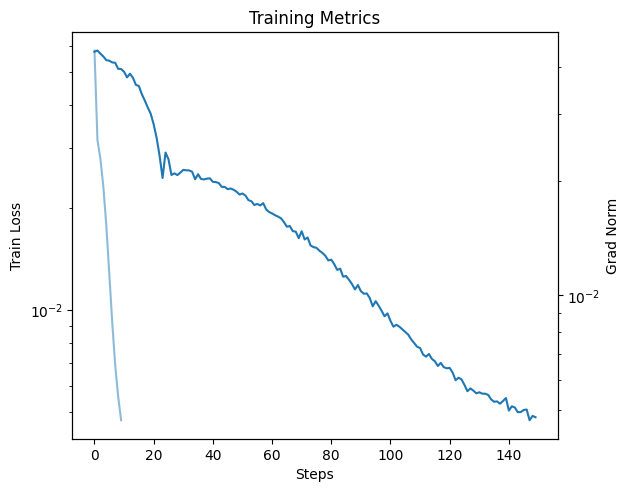

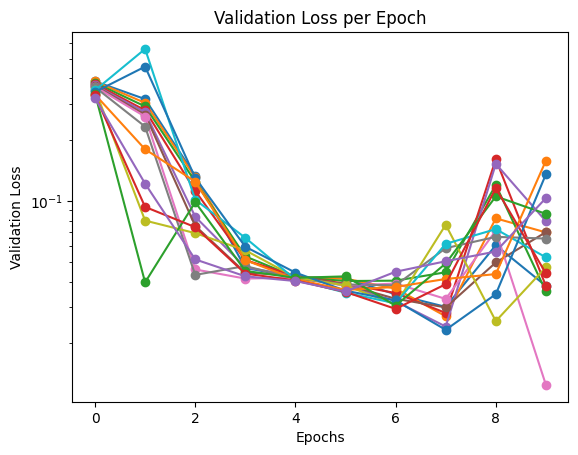

In [9]:
plot_metrics(train_losses, train_gradns, val_losses)

## Save & Load model

In [10]:
def save_model(model: eqx.Module, state: eqx.nn.State, save_dir: str):
    model_path = os.path.join(save_dir, "model.eqx")
    state_path = os.path.join(save_dir, "state.eqx")

    with open(model_path, "wb") as f:
        eqx.tree_serialise_leaves(f, model)

    with open(state_path, "wb") as f:
        eqx.tree_serialise_leaves(f, state)

def load_model(load_dir: str) -> eqx.Module:
    model_template, state_template = eqx.nn.make_with_state(UNet)(in_channels=1, out_channels=1, bilinear=True, key=jax.random.key(0))

    model_path = os.path.join(load_dir, "model.eqx")
    state_path = os.path.join(load_dir, "state.eqx")

    with open(model_path, "rb") as f:
        model =  eqx.tree_deserialise_leaves(f, model_template)

    with open(state_path, "rb") as f:
        state =  eqx.tree_deserialise_leaves(f, state_template)

    return model, state

In [11]:
model_dir = "./weights"

os.makedirs(model_dir, exist_ok=True)
save_model(trained_model, model_state, model_dir)

## Evalutation

In [16]:
model_dir = "./weights"

model, state = load_model(model_dir)

model_eval = eqx.nn.inference_mode(model)
model_eval = eqx.Partial(model_eval, state=state)

@eqx.filter_jit
def aut(model_eval, images):
    # discard state
    deonised, _ = jax.vmap(model_eval)(images[:, None, ...])
    return jnp.squeeze(deonised)

In [13]:
def plot_images(tomo, augmented, gt, cmap = 'viridis', n_cols=2):
    n_images = tomo.shape[0]
    n_rows = (n_images - 1) // n_cols + 1

    n_col_subplots = 3 * n_cols
    h = 4 * n_rows
    w = 4 * n_col_subplots

    fig, axes = plt.subplots(n_rows, n_col_subplots, figsize=(w, h))
    axes = axes.flatten()

    for i in range(n_col_subplots):
        if i % 3 == 0:
            axes[i].set_title("Tomogram")
        elif i % 3 == 1:
            axes[i].set_title("Augmented")
        else:
            axes[i].set_title("Ground Truth")
        axes[i].axis('off')

    for idx in range(n_images):
        axes[3*idx].imshow(tomo[idx], cmap=cmap, interpolation='nearest')
        axes[3*idx].axis('off')

        axes[3*idx + 1].imshow(augmented[idx], cmap=cmap, interpolation='nearest')
        axes[3*idx + 1].axis('off')

        axes[3*idx + 2].imshow(gt[idx], cmap=cmap, interpolation='nearest')
        axes[3*idx + 2].axis('off')

    plt.show()

In [39]:
def identify_atoms(image, num_atoms, min_distance=2, gaussian_sigma=1):
    """
    image: 2D numpy array (원본 이미지)
    num_atoms: 검출할 입자 수
    min_distance: peak 간 최소 거리 (pixels)
    gaussian_sigma: smoothing 용 Gaussian 필터의 σ

    반환값:
    coords: shape (num_atoms, 2) numpy array. 
            각 행은 [y, x] 좌표 (row, column)
    """
    # 1) Gaussian smoothing 으로 노이즈 완화
    img_smooth = gaussian_filter(image, sigma=gaussian_sigma)

    # 2) peak_local_max 으로 local maxima 검출
    coords = peak_local_max(
        img_smooth,
        min_distance=min_distance,
        num_peaks=num_atoms
    )
    print(num_atoms)
    print(coords.shape)
    return coords

from scipy.optimize import linear_sum_assignment

def RMSD(pred, gt):
    """
    pred, gt: shape (N,2) numpy arrays
    1) centroid alignment (translation 보정)
    2) linear_sum_assignment 으로 최적 매칭
    3) Kabsch algorithm 으로 최적 회전 정렬
    4) RMSD 계산
    """
    pred = np.asarray(pred, float)
    gt   = np.asarray(gt,   float)

    # 1) translation 보정: 각자 centroid 를 (0,0) 으로 이동
    pred_c = pred - pred.mean(axis=0)
    gt_c   = gt   - gt.mean(axis=0)

    # 2) cost matrix 계산 (유클리드 거리)
    #    pred_c.shape = (N,2), gt_c.shape = (N,2)
    #    cost[i,j] = ||pred_c[i] - gt_c[j]||
    cost = np.linalg.norm(pred_c[:, None, :] - gt_c[None, :, :], axis=2)

    # 3) Hungarian algorithm 으로 최적 1:1 매칭
    row_ind, col_ind = linear_sum_assignment(cost)

    pred_matched = pred_c[row_ind]
    gt_matched   = gt_c[col_ind]

    # 4) Kabsch algorithm 으로 최적 회전 R 구하기
    C = pred_matched.T @ gt_matched
    V, S, Wt = np.linalg.svd(C)
    d = np.sign(np.linalg.det(Wt.T @ V.T))
    D = np.diag([1, d])
    R = Wt.T @ D @ V.T

    # 5) pred 에 회전 적용
    pred_rot = pred_matched @ R

    # 6) RMSD 계산
    diff = pred_rot - gt_matched
    return np.sqrt(np.mean(np.sum(diff**2, axis=1)))

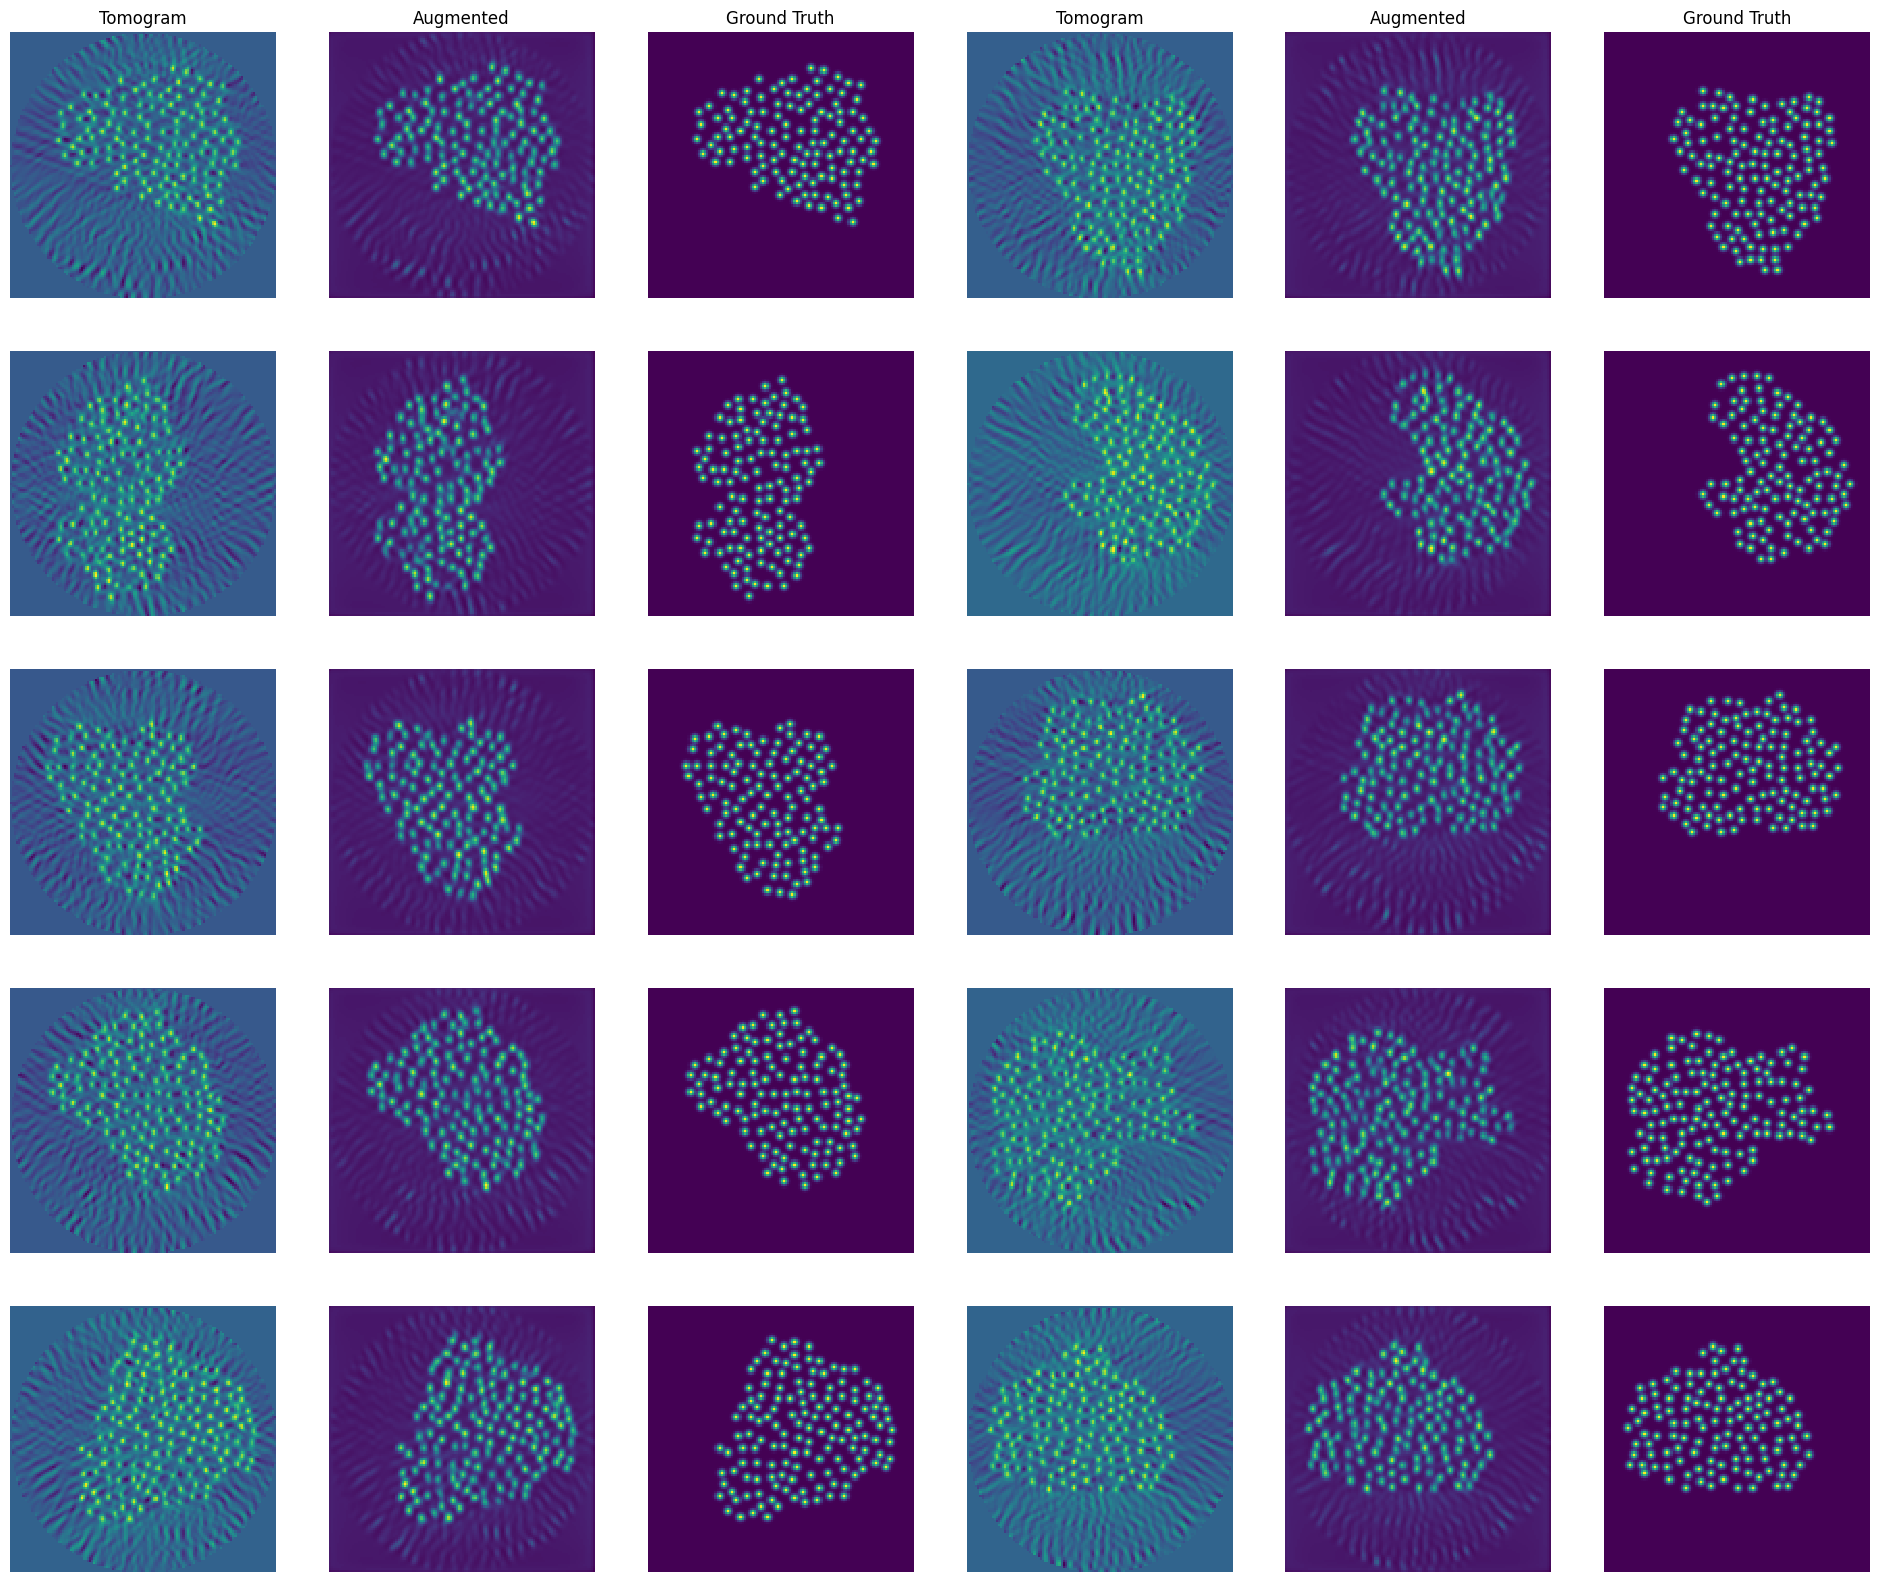

In [40]:
n_images = 5 * 2

gt_images = data["test"]["gt_images"][:n_images]
tomo_images = data["test"]["tomo_images"][:n_images]

augmented = aut(model_eval, tomo_images)

plot_images(tomo_images, augmented, gt_images)

In [ ]:
n_test_data = 10 # data["test"]["gt_images"].shape[0]
for idx in range(n_test_data):
    gt = data["test"]["gt_pos_list"][idx]
    pos = identify_atoms(augmented[idx], gt.shape[0])
    print(f"image {idx}: RMSD={RMSD(pos, gt)}")

121
(121, 2)
image 0: RMSD=8.373874502160902
130
(130, 2)
image 1: RMSD=4.514900749049844
122
(122, 2)
image 2: RMSD=5.347847757302542
118
(118, 2)
image 3: RMSD=6.511183354386896
117
(117, 2)
image 4: RMSD=5.413383974676891
125
(125, 2)
image 5: RMSD=6.326151734911886
125
(125, 2)
image 6: RMSD=6.470857106052793
142
(142, 2)
image 7: RMSD=7.200994201764429
141
(141, 2)
image 8: RMSD=4.201650418208594
124
(124, 2)
image 9: RMSD=6.705879201862575
